## This notebook utilizes the tool to make a refine-sample-coarsen model topography 

In [1]:
import GMesh_torch
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

## GridMesh Class

## Read GEBCO dataset for topography

In [2]:
# Read topo data
#! cp -n /archive/gold/datasets/topography/GEBCO_2023/GEBCO_2023.nc .
#! ln -s /home/Niki.Zadeh/datasets .datasets
with netCDF4.Dataset('.datasets/GEBCO_2020.nc') as nc:
    topo_lons = nc.variables['lon'][:].filled(0.)
    topo_lats = nc.variables['lat'][:].filled(0.)
    topo_elvs = nc.variables['elevation'][:,:].filled(0.)

In [3]:
t_topo_lons=torch.from_numpy(topo_lons).to(device)
t_topo_lats=torch.from_numpy(topo_lats).to(device)
t_topo_elvs=torch.from_numpy(topo_elvs).to(device)

In [4]:
t_topo_elvs

tensor([[ 2829,  2829,  2829,  ...,  2829,  2829,  2829],
        [ 2830,  2830,  2830,  ...,  2830,  2830,  2830],
        [ 2831,  2831,  2831,  ...,  2831,  2831,  2831],
        ...,
        [-4221, -4221, -4221,  ..., -4221, -4221, -4221],
        [-4223, -4223, -4223,  ..., -4223, -4223, -4223],
        [-4227, -4227, -4227,  ..., -4227, -4227, -4227]], dtype=torch.int16)

In [5]:
src_topo_global = GMesh_torch.UniformEDS( t_topo_lons, t_topo_lats, t_topo_elvs, device)
src_topo_global

<UniformEDS 86400 x 43200 (27.810Gb)
lon = <RegularCoord n=86400, dx=0.004166666666666667, rdx=240.0, x0=-180.0, io=-43200, rem=0.0, is-ie=0-86400, periodic=True>
h:tensor([-179.9979, -179.9938, -179.9896,  ...,  179.9896,  179.9937,
         179.9979], dtype=torch.float64)
q:tensor([-180.0000, -179.9958, -179.9917,  ...,  179.9917,  179.9958,
         180.0000])
lat = <RegularCoord n=43200, dx=0.004166666666666667, rdx=240.0, x0=-90, io=-21600, rem=0.0, is-ie=0-43200, periodic=False>
h:tensor([-89.9979, -89.9938, -89.9896,  ...,  89.9896,  89.9938,  89.9979],
       dtype=torch.float64)
q:tensor([-90.0000, -89.9958, -89.9917,  ...,  89.9917,  89.9958,  90.0000])
data.shape = torch.Size([43200, 86400])
data = tensor([[ 2829,  2829,  2829,  ...,  2829,  2829,  2829],
        [ 2830,  2830,  2830,  ...,  2830,  2830,  2830],
        [ 2831,  2831,  2831,  ...,  2831,  2831,  2831],
        ...,
        [-4221, -4221, -4221,  ..., -4221, -4221, -4221],
        [-4223, -4223, -4223,  ..., 

In [6]:
print(' topography grid array shapes: ' , topo_lons.shape,topo_lats.shape,topo_elvs.shape)
print(' topography longitude range:',topo_lons.min(),topo_lons.max())
print(' topography latitude range:',topo_lats.min(),topo_lats.max())
#print(' Is mesh uniform?', GMesh.is_mesh_uniform( topo_lons, topo_lats ) )
#GEBCO_2014_2D.nc
# topography grid array shapes:  (43200,) (21600,) (21600, 43200)
# topography longitude range: -299.995833333 59.9958333333
# topography latitude range: -89.9958333333 89.9958333333
# Is mesh uniform? True
#GEBCO_2020.nc
# topography grid array shapes:  (86400,) (43200,) (43200, 86400)
# topography longitude range: -299.9979166666667 59.99791666666667
# topography latitude range: -89.99791666666667 89.99791666666667
# Is mesh uniform? True

 topography grid array shapes:  (86400,) (43200,) (43200, 86400)
 topography longitude range: -179.99791666666667 179.99791666666667
 topography latitude range: -89.99791666666667 89.99791666666667


## Read the target grid

Terget grid is the underlying finite element 2D supergrid to be used in the Ocean model. Here we choose a 1/4 degree Mercator grid  generated by using the [grid_generation tool](https://github.com/nikizadehgfdl/grid_generation). 

In [7]:
# Read target mesh
#!cp -n /archive/bgr/Datasets/OM5/topo_v4/OM5_025/ocean_hgrid.nc OM5_ocean_hgrid.nc
#! ln -s /home/Niki.Zadeh/datasets .datasets
with netCDF4.Dataset('.datasets/ocean_hgrid.Merc.4deg.nc') as nc:
    lon=nc.variables['x'][::2,::2]
    lat=nc.variables['y'][::2,::2]
t_lon=torch.from_numpy(lon).to(device)
t_lat=torch.from_numpy(lat).to(device)
targG = GMesh_torch.GMesh_torch( lon=t_lon, lat=t_lat )
targG

<GMesh_torch nj:43 ni:90 shape:(43,90)>

In [8]:
#GMesh.pfactor( targG.ni ), GMesh.pfactor( targG.nj )

In [9]:
targG.lon.shape[0],targG.lon[0,0],t_lon[0,0]

(44, tensor(-300., dtype=torch.float64), tensor(-300., dtype=torch.float64))

In [10]:
#import create_topog_refinedSampling as topotool
#jllc,illc,status1=topotool.get_indices1D(topo_lons, topo_lats ,targG.lon[0,0] ,targG.lat[0,0])
#jurc,iurc,status2=topotool.get_indices1D(topo_lons, topo_lats ,targG.lon[0,-1],targG.lat[-1,0])

In [11]:
def convol( levels, h, f, verbose=False ):
    """Coarsens the product of h*f across all levels"""
    levels[-1].height = ( h * f ).reshape(levels[-1].nj,levels[-1].ni)
    for k in range( len(levels) - 1, 0, -1 ):
        if verbose: print('Coarsening {} -> {}'.format(k,k-1))
        levels[k].coarsenby2( levels[k-1] )
    return levels[0].height  

def rough( levels, h, h2min=1.e-7 ):
    """Calculates both mean of H, and variance of H relative to a plane"""
    # Construct weights for moment calculations
    nx = 2**( len(levels) - 1 )
    x = ( np.arange(nx) - ( nx - 1 ) /2 ) * np.sqrt( 12 / ( nx**2 - 1 ) ) # This formula satisfies <x>=0 and <x^2>=1
    X, Y = np.meshgrid( x, x )
    X, Y = X.reshape(1,nx,1,nx), Y.reshape(1,nx,1,nx)
    h = h.reshape(levels[0].nj,nx,levels[0].ni,nx)
    # Now calculate moments
    H2 = convol( levels, h, h ) # mean of h^2
    HX = convol( levels, h, X ) # mean of h * x
    HY = convol( levels, h, Y ) # mean of h * y
    H = convol( levels, h, np.ones((1,nx,1,nx)) ) # mean of h = mean of h * 1
    # The variance of deviations from the plane = <h^2> - <h>^2 - <h*x>^2 - <h*y>^2 given <x>=<y>=0 and <x^2>=<y^2>=1
    return H, H2 - H**2 - HX**2 - HY**2 + h2min


In [12]:
#import imp
#imp.reload(GMesh_torch)


In [13]:


def do_RSC_new(targG,src_topo_global,NtileI=1, NtileJ=1, max_refinement=10):
    """Apply the RSC algoritm using a fixed number of refinements max_refinement"""
    di, dj = targG.ni // NtileI, targG.nj // NtileJ
    assert di*NtileI == targG.ni
    assert dj*NtileJ == targG.nj
    print('window size dj,di =',dj,di,'full model nj,ni=',targG.nj, targG.ni)
    Hcnt = np.zeros((targG.nj, targG.ni)) # Diagnostic: counting which cells we are working on
    Htarg, H2targ = np.zeros((targG.nj, targG.ni)), np.zeros((targG.nj, targG.ni))
    for j in range(NtileJ ):
        csj, sj = slice( j*dj, (j+1)*dj ), slice( j*dj, (j+1)*dj+1 )
        for i in range(NtileI ):
            csi, si = slice( i*di, (i+1)*di ), slice( i*di, (i+1)*di+1 ) # Slices of target grid
            Hcnt[csj,csi] = Hcnt[csj,csi] + 1 # Diagnostic: counting which cells we are working on
            G = GMesh_torch.GMesh_torch( lon=targG.lon[sj,si], lat=targG.lat[sj,si],device=device )
            print('J,I={},{} {:.1f}%, {}\n   window lon={}:{}, lat={}:{}\n   jslice={}, islice={}'.format( \
                j, i, 100*(j*NtileI+i)/(NtileI*NtileJ), G, G.lon.min(), G.lon.max(), G.lat.min(), G.lat.max(), sj, si ))
            levels = G.refine_loop( src_topo_global, resolution_limit=False, fixed_refine_level=max_refinement, timers=False, verbose=True)
            ## Use nearest neighbor topography to populate the finest grid
            levels[-1].project_source_data_onto_target_mesh( src_topo_global )
            ## Now recursively coarsen
            h, h2 = rough( levels, levels[-1].height )
            # Store window in final array
            Htarg[csj,csi] = h
            H2targ[csj,csi] = h2
    print( Hcnt.min(), Hcnt.max(), '<-- should both be 1 for full model' )
    return  Htarg, H2targ
    
st = time.time()
NtileI, NtileJ, max_refinement = 1, 1, 8
Htarg, H2targ = do_RSC_new(targG,src_topo_global,NtileI, NtileJ, max_refinement)    
et = time.time() - st
print('Execution time:', et, 'seconds')

#After every refinement the number of hits increases by almost a factor of 4. 
#So when more than 25% is hit, upon a refinement the resolution of refined grid 
# becomes more than the resolution of the source and each source point
# gets hit multiple times and the algorithm should be considered as converged.
#
#NItile=NJtile=1
#numpy cpu
#rf=8  Hit  253624320  out of  2688360168  cells,    9.4341644776221  percent, time: 141.05 seconds
#rf=9  Hit 1014497280  out of  2688508800  cells,   37.7345716703624  percent, time: 570.34 seconds 
#torch cpu
#rf=6  Hit   15851520  out of  2687952352  cells,    0.5897247392873  percent, time:   1.45 seconds
#rf=8  Hit  253624320  out of  2688297936  cells,    9.4343828711699  percent, time:   8.28 seconds
#rf=9  Hit 1014497280  out of  2688384332  cells,   37.7363187221550  percent, time:  20.34 seconds
#rf=10 Hit 4057989120  out of  3175139396  cells,  127.8050697588963  percent, time: 153.27 seconds



window size dj,di = 43 90 full model nj,ni= 43 90
J,I=0,0 0.0%, <GMesh_torch nj:43 ni:90 shape:(43,90)>
   window lon=-300.0:60.0, lat=-66.51326044311185:63.11375440256549
   jslice=slice(0, 44, None), islice=slice(0, 91, None)
Refine level 0 <GMesh_torch nj:43 ni:90 shape:(43,90)>
Refine level 1 <GMesh_torch nj:86 ni:180 shape:(86,180)>
Refine level 2 <GMesh_torch nj:172 ni:360 shape:(172,360)>
Refine level 3 <GMesh_torch nj:344 ni:720 shape:(344,720)>
Refine level 4 <GMesh_torch nj:688 ni:1440 shape:(688,1440)>


Refine level 5 <GMesh_torch nj:1376 ni:2880 shape:(1376,2880)>
Refine level 6 <GMesh_torch nj:2752 ni:5760 shape:(2752,5760)>
Refine level 7 <GMesh_torch nj:5504 ni:11520 shape:(5504,11520)>
Refine level 8 <GMesh_torch nj:11008 ni:23040 shape:(11008,23040)>
 Hit  253624320  out of  2688297936  cells,  9.434382871169976  percent
1.0 1.0 <-- should both be 1 for full model
Execution time: 8.454418897628784 seconds


In [14]:
targG.lon

tensor([[-300., -296., -292.,  ...,   52.,   56.,   60.],
        [-300., -296., -292.,  ...,   52.,   56.,   60.],
        [-300., -296., -292.,  ...,   52.,   56.,   60.],
        ...,
        [-300., -296., -292.,  ...,   52.,   56.,   60.],
        [-300., -296., -292.,  ...,   52.,   56.,   60.],
        [-300., -296., -292.,  ...,   52.,   56.,   60.]], dtype=torch.float64)

In [15]:
Htarg.min(),Htarg.max(),Htarg.mean(),Htarg.std(),H2targ.min(),H2targ.max(),H2targ.mean(),H2targ.std()
#numpy cpu
#(-6005.377227783203, 5070.64518737793, -2577.6045396080312, 2298.6823638021924,
# 15.688505715721965, 3949778.232566513, 215027.351387799, 391352.31195243995)
#torch cpu
#(-6005.377197265625, 5070.655120849609, -2577.601876764026, 2298.68199945539,
# 15.688113937212114, 3949765.575778824, 215028.10028821323, 391353.38031641796)

(-6005.377197265625,
 5070.655120849609,
 -2577.601876764026,
 2298.68199945539,
 15.688113937212114,
 3949765.575778824,
 215028.10028821323,
 391353.38031641796)

In [16]:
#!\rm new_topo*

In [17]:
with netCDF4.Dataset('new_topo_OM5_grid_r{}_{}x{}.nc'.format(max_refinement, NtileI, NtileJ),'w','clobber') as nc:
    nx = nc.createDimension('nx', Htarg.shape[1])
    ny = nc.createDimension('ny', Htarg.shape[0])
    ntiles = nc.createDimension('ntiles', 1)
    z = nc.createVariable('depth', float, ('ny','nx') )
    z.units='meters'
    z2 = nc.createVariable('h2', float, ('ny','nx'))
    z2.units='meters^2'
    z[:,:] = -Htarg[:,:]
    z2[:,:] = H2targ[:,:]

In [18]:
#plt.pcolormesh( targG.lon, targG.lat, Htarg ); plt.colorbar();

In [19]:
!ls new_topo*

new_topo_OM5_grid_r6_1x1.nc  new_topo_OM5_grid_r8_1x1.nc


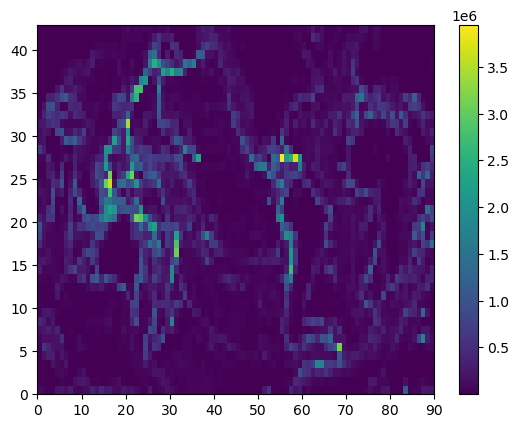

In [20]:
with netCDF4.Dataset('new_topo_OM5_grid_r{}_{}x{}.nc'.format(max_refinement, NtileI, NtileJ)) as nc:
    roughness = nc.variables['h2'][:,:]
#plt.pcolormesh( targG.lon.cpu(), targG.lat.cpu(), roughness.cpu() ); plt.colorbar();
plt.pcolormesh( roughness ); plt.colorbar();       

In [21]:
#depth_r6_30x1 = netCDF4.Dataset('new_topo_OM5_grid_r6_30x1.nc').variables['depth'][:,:]
#depth_r9_30x1 = netCDF4.Dataset('new_topo_OM5_grid_r9_30x1.nc').variables['depth'][:,:]
#depth_r10_30x1 = netCDF4.Dataset('new_topo_OM5_grid_r10_30x1.nc').variables['depth'][:,:]
#plt.pcolormesh( targG.lon, targG.lat, depth_r9_30x1-depth_r10_30x1 ); plt.colorbar(); 

In [22]:
def foo(x,o):
    a=x[0]
    #b=np.floor(a).astype(int) #can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    b=torch.floor(a.float()).int()
    c=np.floor(o).astype(int)
    #c=torch.fmod(a.float(), 1)
    return b,c

f = foo(t_topo_lons.to(device),3.14)
f

(tensor(-180, dtype=torch.int32), 3)

In [23]:
torch.float

torch.float32